# Exercise 1.7
The exercise presented here originates from the book [Data-Driven Sciencs and Engineering](https://databookuw.com/) (aut. Steven L. Brunton and J. Nathan Kutz), which also provide the data, and it is revolved to use Singular Value Decomposition (SVD) to manage complex systems. Such systems typically produce large matrices, which require a lot of space. However, the rank of these are often low, meaning that the main features of the data can be described through recurrent patterns.

SVD is a technique that extracts these patterns, lowering the problem dimension while retaining the information. The SVD of a matrix $\mathbf{X}$, is written as: 
$\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V^*}$
where:
- $\mathbf{U}\in \mathbb{C}^{n \times m}$ is a unitary matrix, its columns are called *left singular vectors* of $\mathbf{X}$.
- $\mathbf{V} \in \mathbb{C}^{n \times m}$ is a unitary matrix, its columns are called *right singular vectors* of $\mathbf{X}$.
- $\mathbf{\Sigma}\in \mathbb{R}^{n \times m}$ is a matrix, its eigenvalues are called *singular values* of $\mathbf{X}$.

In this exercise, $\mathbf{X}$ contains synthetic data on the vorticity from the flow around a cylinder.

### The data
The data for this exercise is provided by the authors of the book. `X_true` is the original data while `n` and `m` are the size of the dimensions of the data.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

cylinder_data = scipy.io.loadmat('..\DATA\CYLINDER_ALL.mat')
print(cylinder_data.keys())

m = cylinder_data['m'].squeeze()
n = cylinder_data['n'].squeeze()
X_true = cylinder_data['VORTALL']

dict_keys(['__header__', '__version__', '__globals__', 'UALL', 'UEXTRA', 'VALL', 'VEXTRA', 'VORTALL', 'VORTEXTRA', 'm', 'n', 'nx', 'ny'])


In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from mpl_toolkits.axes_grid1 import make_axes_locatable

# First set up the figure, the axis, and the plot element we want to animate
def animate_flow(arr, dims, video_name, t=10):
    n, m = dims
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharex=True, sharey=True)
    fig.set_size_inches(n/60, m/60) # sets size relative to image size

    pos = ax.imshow(arr.reshape(n, m, arr.shape[-1], order='C')[:,:,0].T, 
                    cmap='RdBu_r',
                    vmin=X_true.min(),
                    vmax=X_true.max())

    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cb = fig.colorbar(pos, cax=cax)
    total_frames = arr.shape[-1]

    # animation function.  This is called sequentially
    def animate(i):
        pos.set_array(arr.reshape(n, m, arr.shape[-1], order='C')[:,:,i].T)
        cax.cla()
        fig.colorbar(pos, cax=cax)
        return pos
        
    anim = FuncAnimation(fig, animate, frames=total_frames, interval=5)
    anim.save(video_name, fps=total_frames/t, extra_args=['-vcodec', 'libx264'])
    plt.close()

video_name = 'cylinder_flow.mp4'
animate_flow(X_true, (n, m), video_name)

In [3]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/Q6z87wYxkog" title="YouTube video player" frameborder="0"
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

You can see the video at this link: [Fluid flow against the cylinder, raw data](https://youtube.com/playlist?list=PLVQtSptK3D8t6rF28Vs8nMMsHlq9_bFy3)

## (a) - Eigenflow mode and amplitudes
In this part of the exercise the eigenflow modes and amplitudes are calulated and plotted.

Eigenflow modes referes to the left eigenvectors and are interpreted as the spatial modes of the flow.\
Eigenflow amplitudes are the right eigenvectors and are interpreted as the latent space temporal development.

The SVD is calculated using the economy formulation:
$\bf{X} = \bf{\hat{U}}\bf\hat{{\Sigma}}\bf{V^*}$

In [4]:
U, S, VT = np.linalg.svd(X_true, full_matrices=False)
S = np.diag(S)
U.shape, S.shape, VT.shape

((89351, 151), (151, 151), (151, 151))

The first 6 eigenflow modes and amplitudes are plotted below:

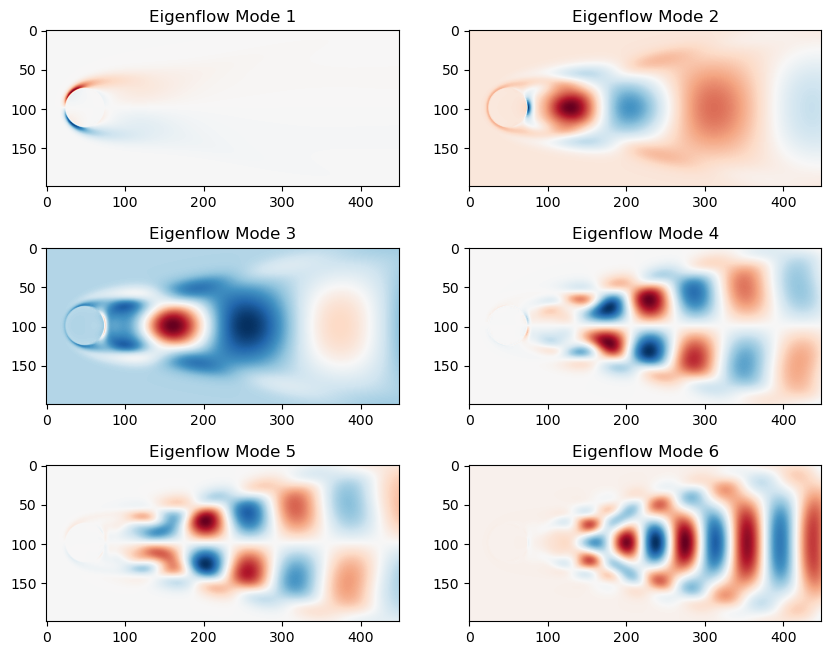

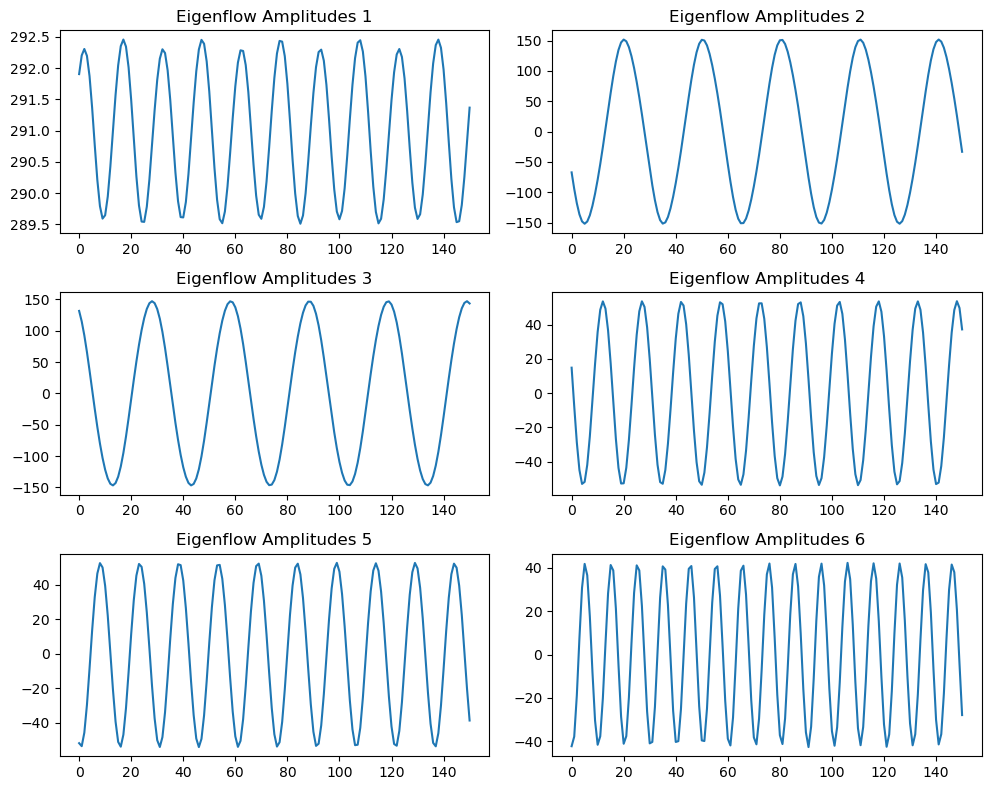

In [5]:
# Eigenflow modes
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
for r, ax in enumerate(axes.ravel()):
    eigen_vector_r = U[:, r]
    ax.imshow(eigen_vector_r.reshape(n, m, order='C').T, cmap='RdBu_r')
    ax.set_title(f"Eigenflow Mode {r+1}")

# Eigenflow amplitudes
SVT = S @ VT
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
for r, ax in enumerate(axes.ravel()):
    eigen_vector_r = SVT[r, :]
    ax.plot(eigen_vector_r)
    ax.set_title(f"Eigenflow Amplitudes {r+1}")
plt.tight_layout()

## (b) - Reconstruction of the flow
To make the reconstruction of the flow more efficient it is possible to truncate the SVD. This is done to a specified rank, termed rank $r$. The approximated vesrions of $\mathbf{X}$ is termed $\mathbf{\tilde{X}}$ and is defined as follows:

$$\mathbf{\tilde{X}} = \sum_{k=1}^{r}\sigma_k\boldsymbol{u}_k\boldsymbol{v}_k^* $$
where:
- $\sigma_k$ is the $k^{th}$ singular value of the system (or eigenvalue of $\Sigma$).
- $\boldsymbol{u}_k$ is the $k^{th}$ column of $U$.
- $\boldsymbol{v}_k$ is the $k^{th}$ column of $V$.


In this part exercise the flow is reconstructed for different recovered levels of energy ($\phi_{E} = 90\%, 99\%$ and $99.9\%$). The squared Frobenius norm is used to estimate the energy: $E_{tot} = ||X||_F^2 $. Consequently, the r-rank approximation that retains the desired level of the total energy of the system, is the smallest rank which satisfies:

$$\begin{equation}||X^{(r)}||_F^2 = E(r) \geq  E_{tot} \cdot \phi_{E} \nonumber \end{equation} $$

In [6]:
E = []
E_org = np.linalg.norm(X_true)**2 # Energy calculated as the squared Frobenius norm
for r in range(U.shape[-1]):
    X_approx = U[:, :r] @ S[:r, :r] @ VT[:r, :]
    E.append(np.linalg.norm(X_approx)**2/E_org) # Energy as a fraction of the original energy
E = np.array(E)

In [7]:
r_modes = []
energy_targets = [0.9, 0.99, 0.999]
for i, energy_target in enumerate(energy_targets):
    r_modes.append(np.min(np.where(E >=energy_target)[0]))
    print(f"For {energy_target*100}% of the energy, {r_modes[i]+1} modes are required")

For 90.0% of the energy, 4 modes are required
For 99.0% of the energy, 8 modes are required
For 99.9% of the energy, 10 modes are required


In the following block of code, we plot the energy distribution and cummulative energy density including energy targets, as required in question (b).

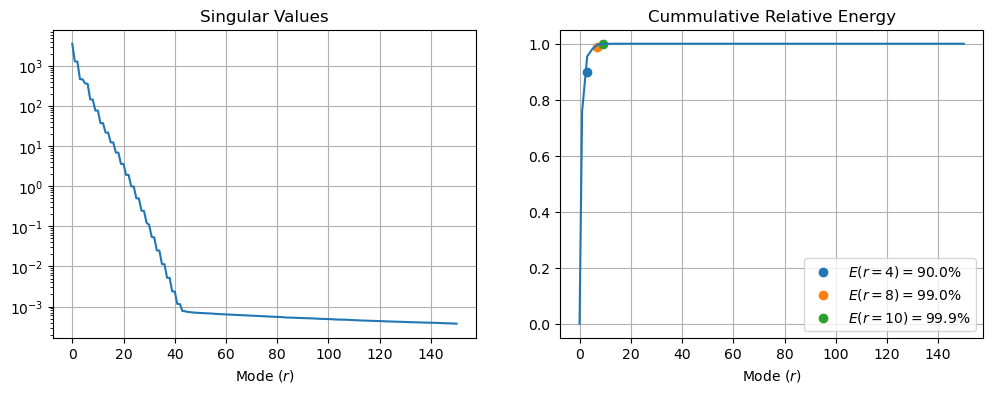

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].semilogy(np.diag(S))
axes[0].set_title('Singular Values')
axes[1].plot(E)
for r_mode, energy_target in zip(r_modes, energy_targets):
    axes[1].scatter(np.array(r_mode), energy_target, label=f"$E(r={r_mode+1}) = {energy_target*100}\%$")
axes[1].set_title('Cummulative Relative Energy')
for ax in axes:
    ax.grid(True)
    ax.set_xlabel('Mode $(r)$')
plt.legend()
plt.show();

Then, we perform different truncations of the SVD: $\bf{\tilde{X}} \approx \bf{\tilde{U}}\bf\tilde{{\Sigma}}\bf{\tilde{V}^*}$ based on the specified energy levels.

In [9]:
X_SVD = np.zeros((X_true.shape + (len(r_modes), )))
X_SVD_error = np.copy(X_SVD)

for i, r in enumerate(r_modes):
    X_SVD[:, :, i] = U[:,:r] @ S[:r,:r] @ VT[:r,:]
    X_SVD_error[:, :, i] = X_true - X_SVD[:, :, i]

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

total_frames = X_true.shape[-1]

# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots(3, 2, figsize=(9, 7), sharey=True)

images = []
labels = ['SVD', 'Error']
zz = [X_SVD, X_SVD_error]

for y, label, z in zip(range(axes.shape[1]), labels, zz):
    pos = []
    for x in range(axes.shape[0]):
        vmin = np.min(z[:, :, x])
        vmax = np.max(z[:, :, x])
        p = axes[x, y].imshow(z[:, 0, x].reshape((n, m), order='C').T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[x, y].set_title(f"{label}: $r = {r_modes[x]+1}$")
        pos.append(p)
        div = make_axes_locatable(axes[x, y])
        cax = div.append_axes('right', '5%', pad=0.1)
        fig.colorbar(p, cax=cax)
    images.append(pos)

plt.tight_layout()

# animation function.  This is called sequentially
def animate(i, zz):
    for idx_im, (image, z) in enumerate(zip(images, zz)):
        for idx_pos, pos in enumerate(image):
            pos.set_array(z[:, i, idx_pos].reshape((n, m), order='C').T)
            images[idx_im][idx_pos] = pos


anim = FuncAnimation(fig, lambda i: animate(i, zz), frames=total_frames, interval=5)

video_name = 'SVD_vort.mp4'
anim.save(video_name, fps=total_frames/10, extra_args=['-vcodec', 'libx264'])
plt.close()

In [11]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/PKZ58XyElRQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share"
allowfullscreen></iframe>

You can see the video at this link: [Single Value Decomposition (SVD) reconstruction of the flow cylinder](https://youtu.be/PKZ58XyElRQ)

In [12]:
sq_norm_error_r_vals = []
for i, r_val in enumerate(r_modes):
    X_approx = U[:,:r_val] @ S[:r_val,:r_val] @ VT[:r_val,:]
    sq_norm_error_r_vals.append(np.linalg.norm(X_approx - X_true)**2)
    print(f"Squared Frobenius norm of error for r={r_val+1}: {sq_norm_error_r_vals[i]}")

Squared Frobenius norm of error for r=4: 753357.9772952065
Squared Frobenius norm of error for r=8: 58421.904997206555
Squared Frobenius norm of error for r=10: 16045.668777409372


## (c) - Truncated SVD.

As specified by the exercise, we chose rank $r=10$, so the rightside vector is:

In [13]:
X_approx = U @ S @ VT

In [14]:
r10 = 10
U_trunc_r10 = U[:,:r10]
S_trunc_r10 = S[:r10,:r10]
VT_trunc_r10 = VT[:r10,:]
X_approx_r10 = U_trunc_r10 @ S_trunc_r10 @ VT_trunc_r10

We plot a randomly chosen snapshot ($k$=15), a reconstruction and the error between them. This helps to compare the SVD results to the original data.

In [15]:
frame_of_interest = 10

W = (S_trunc_r10 @ VT_trunc_r10)
w_k = W[:, frame_of_interest]
X_r10 = U_trunc_r10[:, :r10] @ w_k

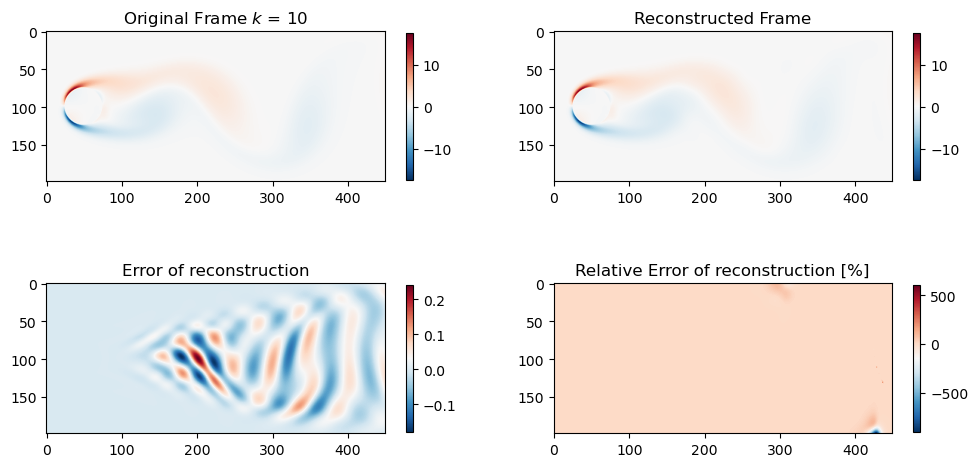

In [16]:
zzs = [X_true[:, frame_of_interest], X_r10, (X_r10 - X_true[:, frame_of_interest]), (X_r10 - X_true[:, frame_of_interest])/X_true[:, frame_of_interest]/100]
titles = [f"Original Frame $k$ = {frame_of_interest}", f"Reconstructed Frame", f"Error of reconstruction", f"Relative Error of reconstruction [%]"]

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, zz, title in zip(axes.ravel(), zzs, titles):
    cs = ax.imshow(zz.reshape(n, m, order='C').T, cmap='RdBu_r')
    fig.colorbar(cs, ax=ax, shrink=0.7)
    ax.set_title(title)
    ax.set_aspect('equal')
plt.show();

The relative error seems high at first glance but when the data is investigated it is revealed that absolutte error is low. This is due to the original value beeing close to zero at the position of the large error.

## (d) - Compute A eigenvalues.

In this exercise, we are required to build a linear regression model to solve the dynamical system $ w_{k+1} = A w_k $. In order to do so, we must create two matrices $W$ and $W'$, which are composed of the columns ($0:149$) and ($1:150$) of the matrix $\Sigma V^*$ respectively, so that the time instants are out of phase of 1 time instant. In this way, the previous system can be written in a more compact way as:

$$W' = AW \,\,\, s.t.\,\,\, A = W'W^{-1}$$

At this point, we can use the SVD to obtain the pseudo-inverse of $W$, which corresponds to the best fit:

$$W' = A (U\Sigma V^*) \Rightarrow W'(V\Sigma^{-1}U^*) = A$$

and:

$$A \sim W'W^{-1} \Rightarrow w_{k+1} \sim A w_k$$

Once we have $A$, its eigenvalues can be computed with a built-in numpy function and then plotted in the complex plain.

As first step, we compute $W$ and $W'$.

In [17]:
W_full = S @ VT
# Create a matrix W with the first 1 through m−1 columns of SigmaxV∗
W = W_full[:, :-1] 
# Create a matrix W_p1 with the 2 through m columns of SigmaxV∗.
W_p1 = W_full[:, 1:]

Then we compute the SVD of $W$ and use it to get its pseudoinverse, which allows us to get $A$ and its eigenvalues.

In [18]:
# compute the SVD of W.
U_W, S_W, VT_W = np.linalg.svd( W , full_matrices = False )
S_W = np.diag(S_W)
W_dagger = np.conjugate(VT_W.T) @ np.linalg.inv(S_W) @ np.conjugate(U_W.T)

# compute A and its eigenvalues.
A = W_p1 @ W_dagger
S_A, V_A = np.linalg.eig(A)

Finally, we plot the eigenvalues in the complex plain.

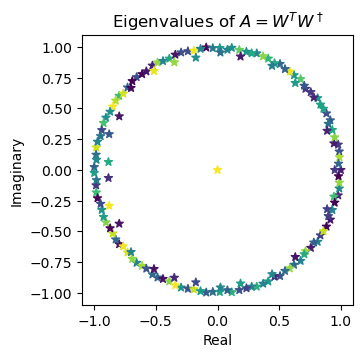

In [19]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = plt.gca()
colors = np.random.rand(len(np.real(S_A)))
ax.scatter( np.real(S_A) , np.imag(S_A) , marker = "*" , c = colors )
ax.set_title('Eigenvalues of $A = W^TW^\dagger$')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
plt.show()

## (e) - Flow reconstruction.

Finally, we are required to us the matrix $A$ that we just obtained to reconstruct the flow field and compare it with the original.

Here, we apply the formula $w_{k+1}=Aw_k,\,\,\forall\,k$ in order to to reconstruct the flow. 

In [20]:
k = 15
w_k = W[:, k-1]
w_k_p1 = W_p1[:, k]
X_approx = U @ A @ w_k

And we plot the result for a specific time-frame with the associated error.

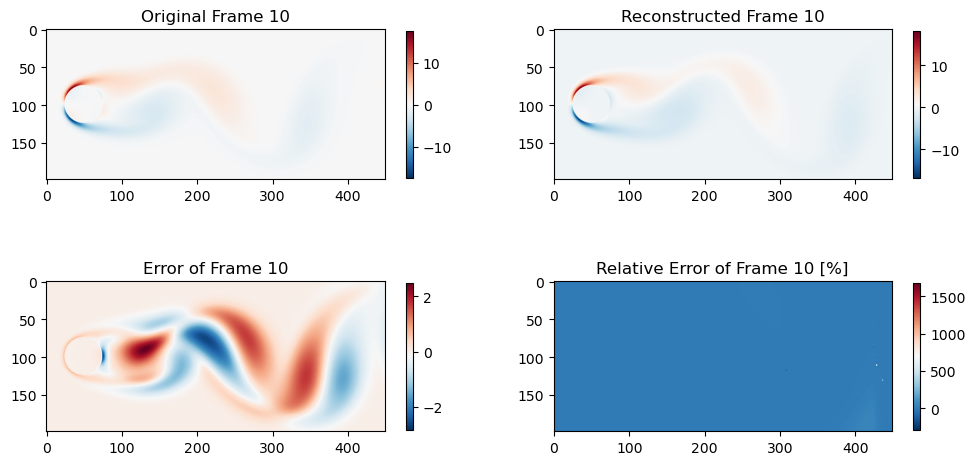

In [21]:
zzs = [X_true[:, frame_of_interest], X_approx, (X_approx - X_true[:, frame_of_interest]), (X_approx - X_true[:, frame_of_interest])/X_true[:, frame_of_interest]/100]
titles = [f"Original Frame {frame_of_interest}", f"Reconstructed Frame {frame_of_interest}", f"Error of Frame {frame_of_interest}", f"Relative Error of Frame {frame_of_interest} [%]"]

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, zz, title in zip(axes.ravel(), zzs, titles):
    cs = ax.imshow( zz.reshape(n, m, order='C').T, cmap="RdBu_r")
    fig.colorbar(cs, ax=ax, shrink=0.7)
    ax.set_title(title)
    ax.set_aspect('equal')
plt.show();
